# Установка и импорт библиотек

In [26]:
!pip install openpyxl
!pip install catboost
!pip install optuna
!pip install scikit-learn
!pip install seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 905.7 kB/s eta 0:00:00a 0:00:01


In [28]:
# Импорт библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
import optuna
from optuna.samplers import TPESampler
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
# Загрузка файла
# Чтение данных
df = pd.read_csv('data/external_montesinho.csv')

# Проверка
print(df.head())

   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0


In [47]:
# Подготовка данных

df = pd.read_csv('data/external_montesinho.csv')

# Конвертируем значения таргетной колонки в признак есть пожар/нет пожара.
df['Classes'] = np.where(df['area'] > 0, 1, 0)

# Удаляем незначимые признаки.
df.drop(["X", "Y", "month", "day", "area"], axis=1, inplace=True)

# Разделение на тренировочную и тестовую выборки
X = df.drop('Classes', axis=1)
y = df["Classes"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("🔹 not_fire: ", df['Classes'].eq(0).sum())
print("🔹 fire: ", df['Classes'].eq(1).sum())


🔹 not_fire:  247
🔹 fire:  270


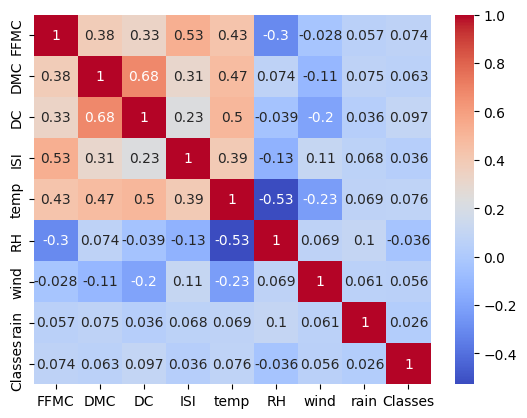

In [48]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [49]:
# Создание Pool для CatBoost
train_pool = Pool(
    X_train,
    y_train,
)

test_pool = Pool(
    X_test,
    y_test,
)

# Функция для оптимизации гиперпараметров с Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'auto_class_weights': 'Balanced',
        'verbose': False,
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'early_stopping_rounds': 50,
    }

    scores = []
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    for train_idx, valid_idx in cv.split(X_train, y_train):
        x_tr, x_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = CatBoostClassifier(**params)
        model.fit(
            x_tr, y_tr,
            eval_set=(x_val, y_val),
            use_best_model=True,
            verbose=0
        )

        # Получаем вероятности
        probs = model.predict_proba(x_val)[:, 1]

        # Превращаем в 0/1 (порог 0.5)
        preds = (probs > 0.5).astype(int)

        # F1-Score
        scores.append(f1_score(y_val, preds))

    return np.mean(scores)

# Отключаем лишние логи Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Оптимизация гиперпараметров
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
)
study.optimize(objective, n_trials=50, show_progress_bar=True)

Best trial: 7. Best value: 0.636676: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


In [50]:
# Обучение модели с лучшими параметрами и оценка

# Создание Pool для CatBoost
final_train_pool = Pool(
    X_train,
    y_train,
)
final_test_pool = Pool(
    X_test,
    y_test,
)


best_params = study.best_params
best_model = CatBoostClassifier(**best_params, verbose=False)
best_model.fit(
    final_train_pool,
    eval_set=final_test_pool,
    verbose=0
)

# Прогноз и оценка
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])}")

              precision    recall  f1-score   support

           0       0.65      0.68      0.67        50
           1       0.69      0.67      0.68        54

    accuracy                           0.67       104
   macro avg       0.67      0.67      0.67       104
weighted avg       0.67      0.67      0.67       104

ROC-AUC: 0.6857407407407408


In [51]:
# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.get_feature_importance()
}).sort_values('importance', ascending=False)

print("Feature importance:")
print(feature_importance)

Feature importance:
  feature  importance
5      RH   21.902796
1     DMC   15.033384
2      DC   14.611021
3     ISI   12.827547
4    temp   12.435659
0    FFMC   12.339286
6    wind   10.460331
7    rain    0.389976


In [40]:
# Сохранение модели
# best_model.save_model("models/external_montesinho.cbm")